# Title: k-NN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_ohe = pd.read_csv("data_ohe.csv") # One-hot encoded
print('Data one-hot encoded shape', data_ohe.shape)
data_ohe.head()

Data one-hot encoded shape (368, 152)


,sample_id,group,age,Alanine,Creatine,Creatinine,Glutamine,Glycine,Histidine,Isoleucine,...,severity_0,severity_1,severity_2,severity_3,sex_0,sex_1,age_cat_0,age_cat_1,age_cat_2,age_cat_3
0,6,2,72,0.411,0.016,0.088,0.705,0.274,0.063,0.077,...,1,0,0,0,0,1,0,0,1,0
1,7,2,89,0.379,0.018,0.069,0.696,0.538,0.034,0.062,...,1,0,0,0,1,0,0,0,0,1
2,9,2,82,0.362,0.058,0.117,0.657,0.311,0.054,0.054,...,1,0,0,0,1,0,0,0,1,0
3,19,2,56,0.394,0.007,0.100,0.783,0.227,0.067,0.084,...,1,0,0,0,0,1,0,1,0,0
4,20,2,87,0.224,0.122,0.155,0.452,0.220,0.055,0.033,...,1,0,0,0,0,1,0,0,0,1


# Prepare data for modeling

In [3]:
# Prepare data for modeling
data_mod=data_ohe.drop(['age', 'sample_id'], axis=1)
print('Shape of onehot encoded data ready for modeling:', data_mod.shape)

# Create X/y variables
X = data_mod.drop(["group"], axis=1)
y = data_mod.group

Shape of onehot encoded data ready for modeling: (368, 150)


In [4]:
from sklearn.model_selection import train_test_split

# Create X/y variables

# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=0
)

print("Train:", X_tr.shape, y_tr.shape)
print("Test:", X_te.shape, y_te.shape)

Train: (257, 149) (257,)
Test: (111, 149) (111,)


In [5]:
# Check the number of samples (patients) in each group
print(y_tr.value_counts())
print(y_tr.value_counts(normalize=True))

2    172
0     66
1     19
Name: group, dtype: int64
2    0.669261
0    0.256809
1    0.073930
Name: group, dtype: float64


**Comment:** There are 172 patients in the group 2 (acute phase of infection), 66 patients in the group 0 (Post-COVID) and 19 patients in the group 1 (post-acute phase of infection). The data is imbalanced and therefore, the logistic regression will be implemented with the parameter: class_weight='balanced'.

# Grid search with cross-validation: all features

- The k-NN classfier is used here for the 3-class problem, however, a mediocre perfomace is expected due to the curse of dimensionality (149 features vs 257 datapoints in the train set). 
- After that, the classfier will also be fit on data with PCA-reduced dimensionality. 

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# k-NN estimator
knn_estimator = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())]) 

# Grid search with cross-validation
# Define grid
grid = [{
        "knn__n_neighbors": [1, 2, 3, 4, 5, 10, 15, 20],  # k
        "knn__weights": ["uniform", "distance"],  # Weighting function
        "knn__p": [1, 2],  # L1 and L2 distance metrics
        }]

knn_gscv = GridSearchCV(knn_estimator, grid, cv=10, refit=True, return_train_score=True)

In [7]:
# Fit/evaluate estimator
knn_gscv.fit(X_tr, y_tr)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid=[{'knn__n_neighbors': [1, 2, 3, 4, 5, 10, 15, 20],
                          'knn__p': [1, 2],
                          'knn__weights': ['uniform', 'distance']}],
             return_train_score=True)

In [8]:
# Collect results in a DataFrame
knn_results = pd.DataFrame(
    { 
        "k": knn_gscv.cv_results_["param_knn__n_neighbors"],
        "p": knn_gscv.cv_results_["param_knn__p"],
        "weights": knn_gscv.cv_results_["param_knn__weights"],
        "mean_tr": knn_gscv.cv_results_["mean_train_score"],
        "mean_te": knn_gscv.cv_results_["mean_test_score"],
        "std_te": knn_gscv.cv_results_["std_test_score"],
    }
)

# Ten best combinations according to the mean "test" score
# i.e. the mean score on the 10 validation folds
knn_results.sort_values(by="mean_te", ascending=False).head(15)

,k,p,weights,mean_tr,mean_te,std_te
21,10,1,distance,1.000000,0.856615,0.059253
20,10,1,uniform,0.871165,0.852769,0.058555
18,5,2,uniform,0.873330,0.852769,0.065698
17,5,1,distance,1.000000,0.852462,0.061667
23,10,2,distance,1.000000,0.848923,0.064841
22,10,2,uniform,0.862959,0.848923,0.062325
19,5,2,distance,1.000000,0.848923,0.071358
12,4,1,uniform,0.887164,0.848769,0.065319
13,4,1,distance,1.000000,0.848769,0.060620
30,20,2,uniform,0.848692,0.845077,0.063742


In [9]:
# Print the best estimator
knn_gscv.best_estimator_.named_steps['knn']

KNeighborsClassifier(n_neighbors=10, p=1, weights='distance')

**Comment:** I tried the classifier with [1, 2, 3, 4, 5, 10, 15, 20] neighbors. There are three top results that give the same mean_tr and mean_te! 
(distance metric L1: distance that corresponds to the shortest path between them with only horizontal and vertical steps)

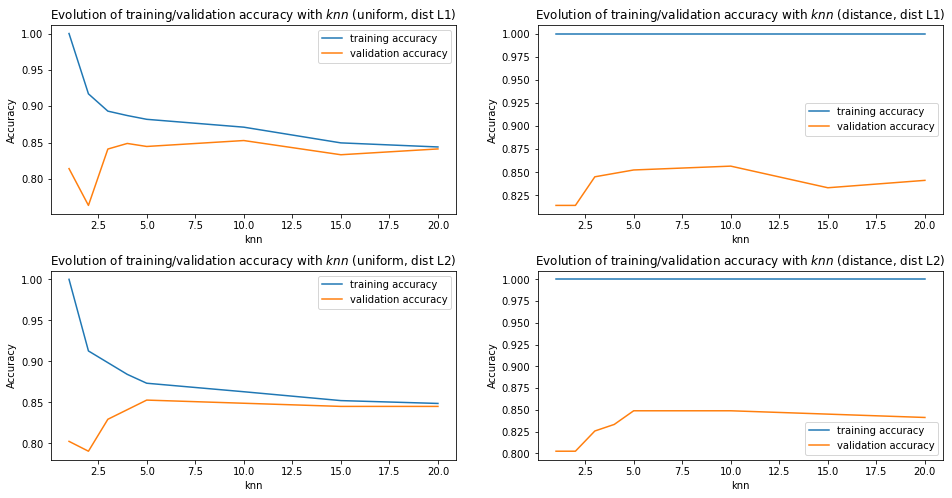

<Figure size 864x1440 with 0 Axes>

In [10]:
# Visualize the train and validation curves separately for "knn__weights": ["uniform", "distance"] and the L1 and L2 distance metrics "knn__p": [1, 2], respectively.
weights_type=["uniform", "distance"]

knn_weights_type=knn_results[knn_results['weights']=='uniform']

fig, axes = plt.subplots(nrows = 2,
                        ncols = 2,
                        figsize = (16,8),
                        gridspec_kw = ({"wspace": 0.2, "hspace": 0.3}))

plt.figure(figsize=(12,20))

for i in range(len(weights_type)):
    
    for p in [1,2]:
        
        knn_weights_type=knn_results[(knn_results['weights']==weights_type[i])&(knn_results['p']==p)]
        
        if p==1:
            axes[0,i].plot(knn_weights_type["k"], knn_weights_type["mean_tr"], label='training accuracy')
            axes[0,i].plot(knn_weights_type["k"], knn_weights_type["mean_te"],  label='validation accuracy')
            
            axes[0,i].set_xlabel('knn')
            axes[0,i].legend()
            axes[0,i].set_ylabel('Accuracy')
            axes[0,i].set_title("Evolution of training/validation accuracy with $knn$ ({}, dist L{})".format(weights_type[i],p))
    
        else:
            axes[1,i].plot(knn_weights_type["k"], knn_weights_type["mean_tr"], label='training accuracy')
            axes[1,i].plot(knn_weights_type["k"], knn_weights_type["mean_te"],  label='validation accuracy')
            
            axes[1,i].set_xlabel('knn')
            axes[1,i].legend()
            axes[1,i].set_ylabel('Accuracy')
            axes[1,i].set_title("Evolution of training/validation accuracy with $knn$ ({}, dist L{})".format(weights_type[i],p))
    
plt.show()

**Comment:** The knn classifier with the weighting function "distance" is heavily overfitting. 

# Grid search with cross-validation: all features, weights = 'uniform'

In [11]:
# k-NN estimator
knn_estimator = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())]) 

# Grid search with cross-validation
# Define grid
grid = [{
        "knn__n_neighbors": [1, 2, 3, 4, 5, 10, 15, 20],  # k
        "knn__weights": ["uniform"],  # Weighting function
        "knn__p": [1, 2],  # L1 and L2 distance metrics
        }]

knn_gscv = GridSearchCV(knn_estimator, grid, cv=10, refit=True, return_train_score=True)

In [12]:
# Fit/evaluate estimator
knn_gscv.fit(X_tr, y_tr)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid=[{'knn__n_neighbors': [1, 2, 3, 4, 5, 10, 15, 20],
                          'knn__p': [1, 2], 'knn__weights': ['uniform']}],
             return_train_score=True)

In [13]:
# Collect results in a DataFrame
knn_results = pd.DataFrame(
    { 
        "k": knn_gscv.cv_results_["param_knn__n_neighbors"],
        "p": knn_gscv.cv_results_["param_knn__p"],
        "weights": knn_gscv.cv_results_["param_knn__weights"],
        "mean_tr": knn_gscv.cv_results_["mean_train_score"],
        "mean_te": knn_gscv.cv_results_["mean_test_score"],
        "std_te": knn_gscv.cv_results_["std_test_score"],
    }
)

# Ten best combinations according to the mean "test" score
# i.e. the mean score on the 10 validation folds
knn_results.sort_values(by="mean_te", ascending=False).head(10)

,k,p,weights,mean_tr,mean_te,std_te
9,5,2,uniform,0.873330,0.852769,0.065698
10,10,1,uniform,0.871165,0.852769,0.058555
11,10,2,uniform,0.862959,0.848923,0.062325
6,4,1,uniform,0.887164,0.848769,0.065319
13,15,2,uniform,0.852150,0.845077,0.058917
15,20,2,uniform,0.848692,0.845077,0.063742
8,5,1,uniform,0.881971,0.844615,0.057321
14,20,1,uniform,0.843932,0.841231,0.073289
4,3,1,uniform,0.893215,0.841077,0.057966
7,4,2,uniform,0.884132,0.841077,0.069217


In [14]:
# Print the best estimator
knn_gscv.best_estimator_.named_steps['knn']

KNeighborsClassifier()

**Comment:** I tried the classifier with [1, 2, 3, 4, 5, 10, 15, 20] neighbors. There are three top results that give the same mean_tr and mean_te! 
(distance metric L1: distance that corresponds to the shortest path between them with only horizontal and vertical steps)

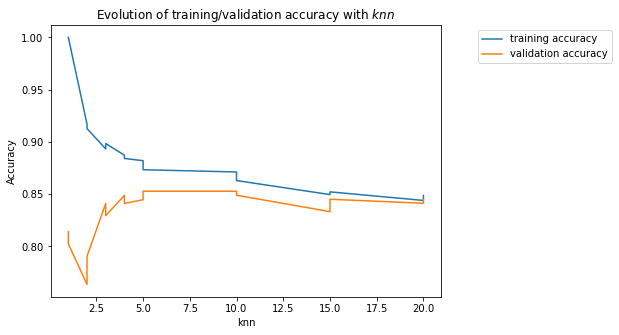

In [15]:
# Visualize the train and validation curves
plt.figure(figsize=(7,5))

# Plot training/validation accuracy curves
plt.plot(knn_results["k"], knn_results["mean_tr"], label='training accuracy')
plt.plot(knn_results["k"], knn_results["mean_te"],  label='validation accuracy')

plt.xlabel('knn')
plt.legend(bbox_to_anchor=(1.45,1), loc="upper right")
plt.ylabel('Accuracy')
plt.title("Evolution of training/validation accuracy with $knn$")
plt.show()

In [16]:
from sklearn.metrics import classification_report

knn_gscv.predict(X_te)

test_score_knn=knn_gscv.score(X_te, y_te)*100
%store test_score_knn
print('Test score', np.round(test_score_knn,3))

# Classification report
y_te_preds_knn = knn_gscv.predict(X_te)
%store y_te_preds_knn
print(classification_report(y_true=y_te, y_pred=y_te_preds_knn))

# Extract probabilities
prob_knn = knn_gscv.predict_proba(X_te)
%store prob_knn

Stored 'test_score_knn' (float64)
Test score 83.784
Stored 'y_te_preds_knn' (ndarray)
              precision    recall  f1-score   support

           0       0.79      0.82      0.81        28
           1       0.33      0.11      0.17         9
           2       0.87      0.93      0.90        74

    accuracy                           0.84       111
   macro avg       0.67      0.62      0.63       111
weighted avg       0.81      0.84      0.82       111

Stored 'prob_knn' (ndarray)


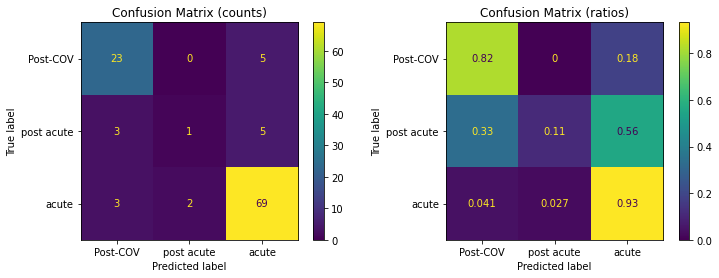

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots the standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(
    y_te, knn_gscv.predict(X_te), display_labels=['Post-COV','post acute', 'acute'], ax=ax1)

# Plots the normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(
    y_te, knn_gscv.predict(X_te), normalize="true", display_labels=['Post-COV','post acute', 'acute'], ax=ax2)

plt.show()

**Comment:** The overall model accuracy is 83.78%, which is higher than the best accuracy obtained with logistic regression and the radom forest. The recall for predicting patients in the acute phase and the post-COVID is as high as 93% and 82%, respectively. The model predicts only 3 patients being in the post acute phase of infection (only one of them correctly). 56% of patients being in the post acute phase of infection are predicted as being in the acute phase. 

# SMOTE: Grid search with cross-validation: all features, weights = 'uniform'

In [18]:
# Oversample with SMOTE and random undersample for imbalanced dataset

from collections import Counter
from imblearn.over_sampling import SMOTE

# summarize class distribution
counter = Counter(y_tr)
print(counter)

# transform the dataset
sm = SMOTE(sampling_strategy = {2: 172, 0: 66, 1: 66})
X_tr_bal, y_tr_bal = sm.fit_resample(X_tr, y_tr)

# summarize the new class distribution
counter = Counter(y_tr_bal)
print(counter)

Counter({2: 172, 0: 66, 1: 19})
Counter({2: 172, 1: 66, 0: 66})


In [19]:
# Fit/evaluate estimator
knn_gscv.fit(X_tr_bal, y_tr_bal)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid=[{'knn__n_neighbors': [1, 2, 3, 4, 5, 10, 15, 20],
                          'knn__p': [1, 2], 'knn__weights': ['uniform']}],
             return_train_score=True)

In [20]:
# Collect results in a DataFrame
knn_results = pd.DataFrame(
    { 
        "k": knn_gscv.cv_results_["param_knn__n_neighbors"],
        "p": knn_gscv.cv_results_["param_knn__p"],
        "weights": knn_gscv.cv_results_["param_knn__weights"],
        "mean_tr": knn_gscv.cv_results_["mean_train_score"],
        "mean_te": knn_gscv.cv_results_["mean_test_score"],
        "std_te": knn_gscv.cv_results_["std_test_score"],
    }
)

# Ten best combinations according to the mean "test" score
# i.e. the mean score on the 10 validation folds
knn_results.sort_values(by="mean_te", ascending=False).head(10)

,k,p,weights,mean_tr,mean_te,std_te
0,1,1,uniform,1.000000,0.849032,0.058697
8,5,1,uniform,0.889984,0.842473,0.063220
1,1,2,uniform,1.000000,0.839570,0.075451
5,3,2,uniform,0.914120,0.836022,0.077210
9,5,2,uniform,0.897298,0.832473,0.077165
4,3,1,uniform,0.925077,0.826344,0.073518
6,4,1,uniform,0.884145,0.819570,0.070229
3,2,2,uniform,0.915577,0.816452,0.079859
11,10,2,uniform,0.861847,0.816022,0.080806
7,4,2,uniform,0.884507,0.813118,0.082518


In [21]:
# Print the best estimator
knn_gscv.best_estimator_.named_steps['knn']

KNeighborsClassifier(n_neighbors=1, p=1)

**Comment:** I tried the classifier with [1, 2, 3, 4, 5, 10, 15, 20] neighbors. There are three top results that give the same mean_tr and mean_te! 
(distance metric L1: distance that corresponds to the shortest path between them with only horizontal and vertical steps)

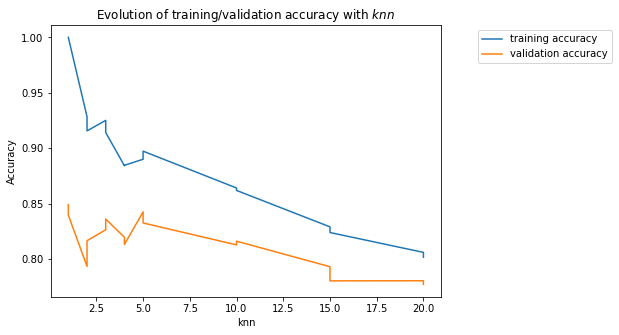

In [22]:
# Visualize the train and validation curves
plt.figure(figsize=(7,5))

# Plot training/validation accuracy curves
plt.plot(knn_results["k"], knn_results["mean_tr"], label='training accuracy')
plt.plot(knn_results["k"], knn_results["mean_te"],  label='validation accuracy')

plt.xlabel('knn')
plt.legend(bbox_to_anchor=(1.45,1), loc="upper right")
plt.ylabel('Accuracy')
plt.title("Evolution of training/validation accuracy with $knn$")
plt.show()

In [23]:
from sklearn.metrics import classification_report

test_score_knn_smote=knn_gscv.score(X_te, y_te)*100
%store test_score_knn_smote
print('Test score', np.round(test_score_knn_smote,3))

# Classification report
y_te_preds_knn_smote = knn_gscv.predict(X_te)
%store y_te_preds_knn_smote
print(classification_report(y_true=y_te, y_pred=y_te_preds_knn_smote))

# Extract probabilities
prob_knn_smote = knn_gscv.predict_proba(X_te)
%store prob_knn_smote

Stored 'test_score_knn_smote' (float64)
Test score 80.18
Stored 'y_te_preds_knn_smote' (ndarray)
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        28
           1       0.38      0.67      0.48         9
           2       0.91      0.86      0.89        74

    accuracy                           0.80       111
   macro avg       0.68      0.74      0.70       111
weighted avg       0.83      0.80      0.81       111

Stored 'prob_knn_smote' (ndarray)


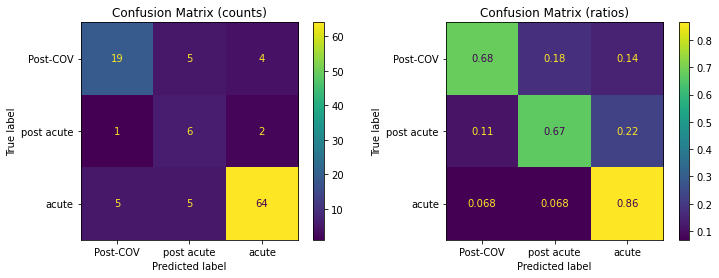

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots the standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(
    y_te, knn_gscv.predict(X_te), display_labels=['Post-COV','post acute', 'acute'], ax=ax1)

# Plots the normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(
    y_te, knn_gscv.predict(X_te), normalize="true", display_labels=['Post-COV','post acute', 'acute'], ax=ax2)

plt.show()

**Comment:** When oversampling the smallest class using SMOTE (Synthetic Minority Oversampling Technique), the k-NN classifier predicts 18 patients being in the post acute phase of infection (4 of them correctly). Among the 9 patients being in the post acute phase, 2 are predicted to be post-COVID, 2 in three in the acute phase, and 4 of them (44%) are predicted correctly. \
PS. The results may slightly differ when re-running the notebook.

# PCA

In [25]:
# Standarize data
from sklearn.preprocessing import StandardScaler

# Create Standard scaler
scaler = StandardScaler()

# Rescale the train and test data prior to PCA
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_te)

In [26]:
from sklearn.decomposition import PCA

# Create PCA transformer
pca = PCA(n_components=12)

# Apply PCA to rescaled data
X_tr_12d_rescaled = pca.fit_transform(X_tr_rescaled)
X_te_12d_rescaled = pca.transform(X_te_rescaled)

In [27]:
# k-NN estimator
knn_estimator = Pipeline([("scaler", None), ("knn", KNeighborsClassifier())]) # No StandradScaler() because data scaled prior to PCA

# Grid search with cross-validation
# Define grid
grid = [{
        "knn__n_neighbors": [1, 2, 3, 4, 5, 10, 15, 20],  # k
        "knn__weights": ["uniform"],  # Weighting function
        "knn__p": [1, 2],  # L1 and L2 distance metrics
        }]

knn_gscv = GridSearchCV(knn_estimator, grid, cv=10, refit=True, return_train_score=True)

In [28]:
# Fit/evaluate estimator
knn_gscv.fit(X_tr_12d_rescaled, y_tr)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', None),
                                       ('knn', KNeighborsClassifier())]),
             param_grid=[{'knn__n_neighbors': [1, 2, 3, 4, 5, 10, 15, 20],
                          'knn__p': [1, 2], 'knn__weights': ['uniform']}],
             return_train_score=True)

In [29]:
# Collect results in a DataFrame
knn_results = pd.DataFrame(
    { 
        "k": knn_gscv.cv_results_["param_knn__n_neighbors"],
        "p": knn_gscv.cv_results_["param_knn__p"],
        "weights": knn_gscv.cv_results_["param_knn__weights"],
        "mean_tr": knn_gscv.cv_results_["mean_train_score"],
        "mean_te": knn_gscv.cv_results_["mean_test_score"],
        "std_te": knn_gscv.cv_results_["std_test_score"],
    }
)

# Ten best combinations according to the mean "test" score
# i.e. the mean score on the 10 validation folds
knn_results.sort_values(by="mean_te", ascending=False).head(10)

,k,p,weights,mean_tr,mean_te,std_te
10,10,1,uniform,0.861655,0.856615,0.056274
12,15,1,uniform,0.852577,0.852462,0.056024
7,4,2,uniform,0.885005,0.852154,0.037650
14,20,1,uniform,0.850412,0.848462,0.046635
6,4,1,uniform,0.881544,0.844769,0.061386
8,5,1,uniform,0.866846,0.844615,0.061880
11,10,2,uniform,0.857768,0.844615,0.050965
9,5,2,uniform,0.878521,0.840462,0.065889
13,15,2,uniform,0.849121,0.837385,0.063145
4,3,1,uniform,0.898405,0.836923,0.061600


In [30]:
# Print the best estimator
knn_gscv.best_estimator_.named_steps['knn']

KNeighborsClassifier(n_neighbors=10, p=1)

**Comment:** I tried the classifier with [1, 2, 3, 4, 5, 10, 15, 20] neighbors. There are three top results that give the same mean_tr and mean_te! 
(distance metric L1: distance that corresponds to the shortest path between them with only horizontal and vertical steps)

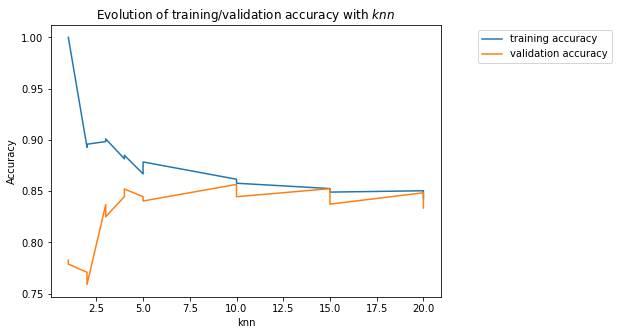

In [31]:
# Visualize the train and validation curves
plt.figure(figsize=(7,5))

# Plot training/validation accuracy curves
plt.plot(knn_results["k"], knn_results["mean_tr"], label='training accuracy')
plt.plot(knn_results["k"], knn_results["mean_te"],  label='validation accuracy')

plt.xlabel('knn')
plt.legend(bbox_to_anchor=(1.45,1), loc="upper right")
plt.ylabel('Accuracy')
plt.title("Evolution of training/validation accuracy with $knn$")
plt.show()

In [32]:
from sklearn.metrics import classification_report

test_score_knn_pca=knn_gscv.score(X_te_12d_rescaled, y_te)*100
%store test_score_knn_pca
print('Test score', np.round(test_score_knn_pca,3))

# Classification report
y_te_preds_knn_pca = knn_gscv.predict(X_te_12d_rescaled)
%store y_te_preds_knn_pca
print(classification_report(y_true=y_te, y_pred=y_te_preds_knn_pca))

# Extract probabilities
prob_knn_pca = knn_gscv.predict_proba(X_te_12d_rescaled)
%store prob_knn_pca

Stored 'test_score_knn_pca' (float64)
Test score 81.081
Stored 'y_te_preds_knn_pca' (ndarray)
              precision    recall  f1-score   support

           0       0.74      0.71      0.73        28
           1       0.00      0.00      0.00         9
           2       0.83      0.95      0.89        74

    accuracy                           0.81       111
   macro avg       0.52      0.55      0.54       111
weighted avg       0.74      0.81      0.77       111

Stored 'prob_knn_pca' (ndarray)


C:\Users\marta\anaconda3\envs\adsml\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marta\anaconda3\envs\adsml\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marta\anaconda3\envs\adsml\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


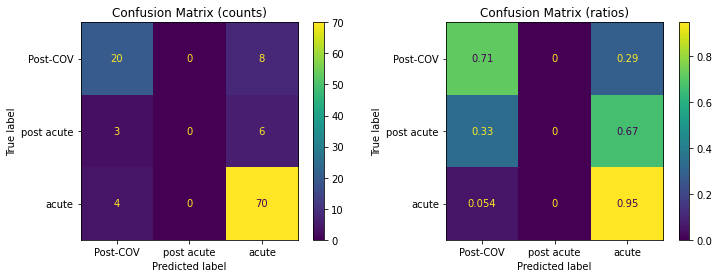

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots the standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(
    y_te, knn_gscv.predict(X_te_12d_rescaled), display_labels=['Post-COV','post acute', 'acute'], ax=ax1)

# Plots the normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(
    y_te, knn_gscv.predict(X_te_12d_rescaled), normalize="true", display_labels=['Post-COV','post acute', 'acute'], ax=ax2)

plt.show()

**Comment:** The model fit on data with PCA-reduced dimensionality does not predict any patients in the post acute phase of infection. The patients in the acute phase of infection are correctly predicted 95% of times.